### Importing libraries

In [93]:
import numpy as np
import cv2
import os
import tensorflow as tf
import pickle

from sklearn.model_selection import train_test_split # for splitting data
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator # for image augmentation
from keras.utils.np_utils import to_categorical # for one-hot encoding
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, \
                                    MaxPooling2D, \
                                    Flatten, \
                                    Dense, \
                                    Dropout


In [94]:
path = 'mnist_png/training'
images = list()
class_number_labels = list()
test_ratio = 0.2
validation_ratio = 0.2 
num_of_imgs_each_list = list()
image_dimensions = (32, 32, 3)

In [95]:
list_of_classes = os.listdir(path)
num_of_classes = len(list_of_classes)
print("Number of classes: ", num_of_classes)

Number of classes:  10


In [96]:
# getting access to each class
for class_num in range (0, num_of_classes):
    # list of images in each class
    list_of_images = os.listdir(path + "/" + str(class_num))
    # getting access to each image in each class
    for img_name in list_of_images:
        
        img = cv2.imread(path + "/" + str(class_num) + "/" + img_name)
        img = cv2.resize(img, (image_dimensions[0], image_dimensions[1]))
        images.append(img)
        class_number_labels.append(class_num)

print(len(images))
print(len(class_number_labels))

60000
60000


In [97]:
images = np.array(images) # converting to numpy array
class_number_labels = np.array(class_number_labels) # converting to numpy array
print(images.shape)
print(class_number_labels.shape)

(60000, 32, 32, 3)
(60000,)


In [98]:
# splitting data into train, test and validation
X_train, X_test, Y_train, Y_test = train_test_split(images, class_number_labels, test_size=test_ratio)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_ratio)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(38400, 32, 32, 3)
(12000, 32, 32, 3)
(9600, 32, 32, 3)


In [99]:
# creating a list that holds the number of images in each class
for num_of_imgs_each_name in range(0, num_of_classes):
    num_of_imgs_each = len(np.where(Y_train==num_of_imgs_each_name)[0]) # getting the length of the list of appearances of each number (by index)
    num_of_imgs_each_list.append(num_of_imgs_each)

print(num_of_imgs_each_list)

[3748, 4304, 3824, 3891, 3739, 3508, 3819, 4027, 3763, 3777]


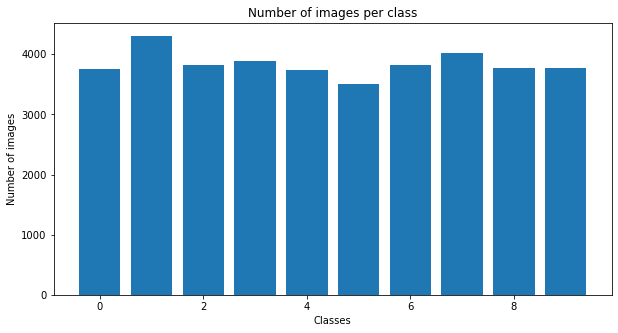

In [100]:
# Plotting the number of images in each class
plt.figure(figsize=(10,5))
plt.bar(range(0, num_of_classes), num_of_imgs_each_list)
plt.title("Number of images per class")
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.show()

In [101]:
def pre_processing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img) # distribute the lightness of the image evenly
    img = img/255 # better for training processes
    return img

In [102]:
# Applying the pre-processing function to each image of the training, testing, and valdiation sets
X_train = np.array(list(map(pre_processing, X_train)))
X_test = np.array(list(map(pre_processing, X_test)))
X_validation = np.array(list(map(pre_processing, X_validation)))

In [103]:
# Adding the depth that is needed for the CNN to run properly to each image in each set
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)

In [104]:
# Augment images (add zoom, rotation, etc.)
# This makes the dataset more generic
data_generator = ImageDataGenerator(width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    shear_range=0.1,
                                    rotation_range=10)

# we don't generate images before training but generate as we go along during the train process
# we want the generator to know the dataset beforehand
# the images would be in batches
# we request a batch, it would augment, and send it back
data_generator.fit(X_train)

# one hot encoding our matrices is necessary for the network
Y_train = to_categorical(Y_train, num_of_classes)
Y_test = to_categorical(Y_test, num_of_classes)
Y_validation = to_categorical(Y_validation, num_of_classes)


In [105]:
# Initializing an optimizer
my_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# the model is based on the LeNet model
def my_model():
    num_of_filters = 60
    size_of_filter_1 = (5, 5)
    size_of_filter_2 = (3, 3)
    size_of_pool = (2, 2)
    num_of_nodes = 500

    model = Sequential()
    
    # adding the 1st convolutional layer
    model.add((Conv2D(num_of_filters, size_of_filter_1, input_shape=(image_dimensions[0], image_dimensions[1], 1), activation='relu')))
    # adding the 2nd convolutional layer
    model.add((Conv2D(num_of_filters, size_of_filter_1, activation='relu')))
    # adding a pooling layer 
    model.add(MaxPooling2D(pool_size=size_of_pool))
    # adding other convolutional layers
    model.add((Conv2D(num_of_filters//2, size_of_filter_2, activation='relu')))
    model.add((Conv2D(num_of_filters//2, size_of_filter_2, activation='relu')))
    # adding another pooling layer 
    model.add(MaxPooling2D(pool_size=size_of_pool))
    # adding a dropout layer(helps to reduce overfitting and it's making it more generic)
    model.add(Dropout(0.5))
    # adding a flattening layer
    model.add(Flatten())
    # adding a dense layer
    model.add(Dense(num_of_nodes, activation='relu'))
    # adding another dropout layer
    model.add(Dropout(0.5))
    # adding another dense layer
    model.add(Dense(num_of_classes, activation='softmax'))
    # compiling the model and mentioning the optimizer and loss function (cross entropy) and metrics (accuracy)
    model.compile(my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [106]:
# creating our model
model = my_model()
# checking the model summary to see the parameters of the model
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [107]:
# defining variables used in training and requesting
batch_size_val = 50
epochs_val = 10
steps_per_epoch_val = 2000

In [ ]:
# running the training at the same time requesting in batches that we need images
history = model.fit_generator(data_generator.flow(
                                                  X_train, 
                                                  Y_train, 
                                                  batch_size=batch_size_val
                                                 ), 
                              steps_per_epoch=steps_per_epoch_val, 
                              epochs=epochs_val, 
                              validation_data=(
                                               X_validation, 
                                               Y_validation
                                              ),
                              shuffle=1            
                             )
                             

In [ ]:
# plotting grphs to see the variation in accuracy and loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epochs')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epochs')

plt.show()

# checking the score of the model
score = model.evaluate(X_test, Y_test, verbose=0)

print("Test score: ", score[0]) # printing the test score
print("Test accuracy: ", score[1]) # printing the test accuracy


In [ ]:
# saving the file so that we can use it in our testing model 
# saving the model as a pickle object
pickle_out = open("trained_model.p", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()


Learned from the YouTube channel: Murtaza's Workshop<br><br>
Text Detection using Neural Networks | OPENCV Python